In [1]:
import gym

import numpy as np
import random
from collections import namedtuple, deque
import pandas as pd
import matplotlib.pyplot as plt

from Agent import Agent

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
sum_gradients = {}
def reset_avg_gradients():
    for name, param in agent.local_model.to(device).named_parameters():
        sum_gradients[name] = torch.zeros(size=param.size()).to(device)

In [3]:
sum_weights = {}
def reset_avg_weights():
    for name, param in agent.local_model.to(device).named_parameters():
        sum_weights[name] = torch.zeros(size=param.size()).to(device)

In [4]:
def calc_avg_gradients(client):
    for i in range(len(client)):
        gradients = {}
        for name, param in client[i].local_model.to(device).named_parameters():
            gradients[name] = param.grad
            sum_gradients[name] += (gradients[name] / no_of_clients)

In [5]:
def cal_avg_weights(client):
    for i in range(len(client)):
        weights = {}
        #print(client[i].local_model.fc1.weight)
        for name, param in client[i].local_model.to(device).named_parameters():
            weights[name] = param
            sum_weights[name] += (weights[name] / no_of_clients) 

In [6]:
def cal_best_gradients(client):
    idx = np.argmax([np.mean(client[i].scores_window) for i in range(len(client))])
    #print([np.mean(client[i].scores_window) for i in range(len(client))])
    #print("idx = ",idx)
    for name, param in client[idx].local_model.to(device).named_parameters():
        sum_gradients[name] = param.grad

In [7]:
def set_new_gradients(sum_gradients,agent):
    for name, param in agent.local_model.to(device).named_parameters():
        param.grad = sum_gradients[name].clone()
        param.grad.requires_grad=True
    agent.optimizer.step()
    agent.optimizer.zero_grad()

In [8]:
def set_new_weights(sum_weights,agent):
    for name, param in agent.local_model.to(device).named_parameters():
        param = sum_weights[name].clone()
        #param.requires_grad=True
    agent.optimizer.step()
    agent.optimizer.zero_grad()

In [9]:
def get_gradients(agent):
    gradients = {}
    for name, param in agent.local_model.to(device).named_parameters():
        gradients[name] = param.grad


In [10]:
environment = 'LunarLander-v2'
env = gym.make(environment)
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
print('State shape: ', state_size)
print('Number of actions: ', action_size)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
no_of_clients = 5
clients = []
fed_rounds = 4
episode_per_fed = 4
grad_update_method = 'weight_avg' #simple_avg, best_score, weight_avg
max_steps=1000          #max number of steps in an episode
       

for i in range(no_of_clients):
    agent = Agent(state_size=state_size, action_size=action_size, seed=5)
    clients.append(agent)
    
for i in range(no_of_clients):
    print(clients[i])

State shape:  8
Number of actions:  4


In [11]:
def dqn(agent,clientID,fed_round):
      # last 100 scores
    #self.eps = self.eps_start                    # initialize epsilon
    for i_episode in range(1, episode_per_fed+1):
        state = env.reset()
        score = 0
        for t in range(max_steps):
            action = agent.act(state, agent.eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        agent.scores_window.append(score)       # save most recent score
        agent.scores.append(score)              # save most recent score
        agent.eps = max(agent.eps_end, agent.eps_decay*agent.eps) # decrease epsilon
        print('\rfed round {} client {} Episode {}\tAverage Score: {:.2f}'.format(fed_round,clientID,i_episode, np.mean(agent.scores_window)), end="")
        if (episode_per_fed*fed_round + i_episode) % 100 == 0:
            print('\rfed round {} client {} Episode {}\tAverage Score: {:.2f}'.format(fed_round,clientID,i_episode, np.mean(agent.scores_window)))
    agent.eps = agent.eps*0.94

In [12]:
for f in range(fed_rounds):
    if grad_update_method == 'simple_avg' or grad_update_method == 'best_score':
        reset_avg_gradients()
    elif grad_update_method == 'weight_avg':
        reset_avg_weights()
    else:
        x = 10 #do nothing as of now

    for i in range(no_of_clients):
        dqn(clients[i],i,f)
    
    if grad_update_method == 'simple_avg': 
        calc_avg_gradients(clients)
    elif grad_update_method == 'best_score':
        cal_best_gradients(clients)
    elif grad_update_method == 'weight_avg':
        cal_avg_weights(clients)
    else:
        x = 10 #do nothing as of now
    for i in range(no_of_clients):
        if grad_update_method == 'simple_avg' or grad_update_method == 'best_score':
            set_new_gradients(sum_gradients,clients[i])
        elif grad_update_method == 'weight_avg':
            set_new_weights(sum_weights,clients[i])
        else:
            x = 10 #do nothing as of now
    

fed round 3 client 4 Episode 4	Average Score: -216.18

In [13]:
########################playing the lunar lander######################################
# def final_play():
#     for e in range(4):
#         state = env.reset()
#         done = False
#         while not done:
#             env.render()
#             action = agent.act(state)
#             next_state, reward, done, _ = env.step(action)
#             agent.step(state, action, reward, next_state, done)
#             state = next_state
#final_play()
#env.close()

In [14]:
def moving_average(vec,window_size):    

    numbers_series = pd.Series(vec)
    windows = numbers_series.rolling(window_size)
    moving_averages = windows.mean()
    moving_averages_list = moving_averages.tolist()
    averaged_v = moving_averages_list[window_size - 1:]
    return(averaged_v)


In [15]:
def plot_graphs(values1,values2,xstring,ystring,title): 
  
    y1 = values1
    y2 = values2
    x1 = [i for i in range(0,len(values1))]
    x2 = [i for i in range(0,len(values2))]
    plt.plot(x1,y1)
    plt.plot(x2,y2,linewidth = 4)
    plt.xlabel(xstring) # naming the x axis      
    plt.ylabel(ystring) # naming the y axis
    plt.title(title) 

    plt.show()


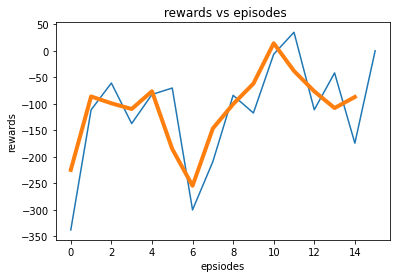

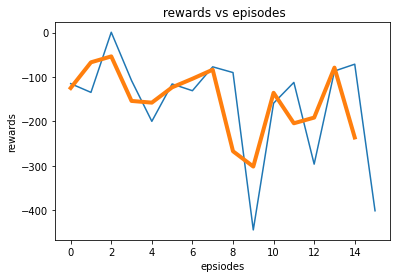

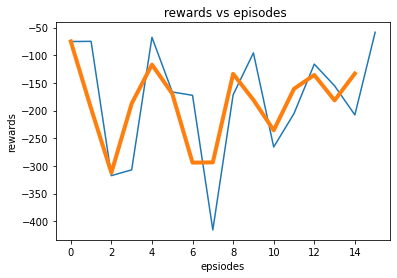

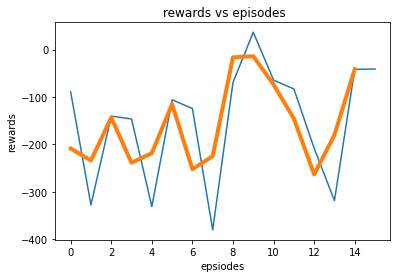

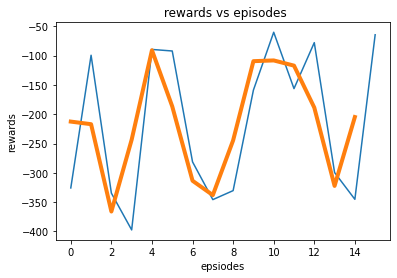

In [16]:
window_size = 2
averaged_scr = []
for i in range(no_of_clients):   
    averaged_ = moving_average(clients[i].scores,window_size)
    #averaged_scr.append(averaged_)
    plot_graphs(clients[i].scores,averaged_,'epsiodes','rewards',' rewards vs episodes')
    #print(averaged_[0:20])
    averaged_scr.append(averaged_)
avg_score = averaged_

In [17]:
df = pd.DataFrame(avg_score)
df.to_csv('trial1.csv')

df2 = pd.DataFrame(averaged_scr)
df2 = df2.transpose()
df2.to_csv('avgGrad_all5clients_targetupdate_after2_set2.csv')
print(df2)

             0           1           2           3           4
0  -224.889952 -124.849427  -75.174331 -208.480920 -212.608194
1   -86.182089  -67.009844 -196.334458 -233.862788 -217.045895
2   -99.081896  -53.691263 -312.423178 -143.340068 -366.010961
3  -109.874468 -153.952847 -187.451391 -238.566701 -243.457762
4   -76.337864 -157.785072 -117.062393 -218.388606  -90.856203
5  -185.346003 -123.320113 -169.497141 -115.173578 -186.739222
6  -254.897566 -104.053470 -294.133519 -252.211291 -313.506691
7  -146.679045  -83.625907 -293.687864 -224.645030 -338.033292
8  -100.688820 -267.171948 -133.752412  -16.425559 -244.627769
9   -61.892110 -301.669338 -180.842649  -14.093973 -109.551212
10   14.357015 -135.649069 -235.663868  -73.821316 -108.277587
11  -38.091290 -204.225142 -160.819806 -145.518016 -117.144330
12  -76.516996 -191.442803 -135.768723 -263.160993 -188.702326
13 -108.055820  -78.965658 -181.631246 -180.080895 -322.326133
14  -87.133426 -236.230542 -133.229193  -41.464722 -204